In [ ]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
maze = np.array([
    [ 3.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  0.,  0.,  1.],
    [ 1.,  1.,  1.,  1.]
])
cnt = 0
for i in maze:
  for j in i:
    if j  > 0 :
      cnt +=1
maze.size
maze_len = len(maze)
# maze_len
# cnt

In [ ]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.15
# cnt

In [ ]:
class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):

        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.cnt_calc()
        self.target =  self._cnt # (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
  
        # if not rat in self.free_cells:
        #     raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)
        

    def cnt_calc (self):
      cnt = 0
      for i in self._maze:
        for j in i:
          if j  > 0 :
            cnt +=1
      self._cnt = cnt
    
    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward =  -3 * self.maze.size #0.02 * cnt
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))
            # self.maze[rat_row, rat_col] = 2  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                 while (not (self._maze[nrow,ncol] == 0)) and (ncol>0) and ((nrow,ncol-1) not in self.visited) and (not (self._maze[nrow,ncol-1] == 0)):
                    ncol -= 1
                    self.visited.add((nrow, ncol))
                    self.maze[nrow, ncol] = 0
            elif action == UP:
              while (not (self._maze[nrow,ncol] == 0)) and (nrow>0) and ((nrow-1,ncol) not in self.visited)and (not (self._maze[nrow-1,ncol] == 0)):
                nrow -= 1
                self.visited.add((nrow, ncol))
                self.maze[nrow, ncol] = 0
            if action == RIGHT:
              while (not (self._maze[nrow,ncol] == 0)) and (ncol<ncols-1) and ((nrow,ncol+1) not in self.visited) and (not (self._maze[nrow,ncol+1] == 0)):
                ncol += 1
                self.visited.add((nrow, ncol))
                self.maze[nrow, ncol] = 0
            elif action == DOWN:
              while (not (self._maze[nrow,ncol] == 0)) and (nrow<nrows-1) and ((nrow+1,ncol) not in self.visited) and (not (self._maze[nrow+1,ncol] == 0)):
                nrow += 1
                self.visited.add((nrow, ncol))
                self.maze[nrow, ncol] = 0
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        # if rat_row == nrows-1 and rat_col == ncols-1:
        if len(self.visited) == self._cnt:
            return 100
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
             return -0.75
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return  0.08 # 0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if len(self.visited) == self._cnt:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if (row>0 and self.maze[row-1,col] == 0.0):
            actions.remove(1)
        if (row<nrows-1 and self.maze[row+1,col] == 0.0) :
            actions.remove(3)

        if (col>0 and self.maze[row,col-1] == 0.0):
            actions.remove(0)
        if (col<ncols-1 and self.maze[row,col+1] == 0.0) :
            actions.remove(2)

        return actions

In [ ]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [ ]:
maze = [
    [ 1.,  3.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  0.,  0.,  1.],
    [ 1.,  1.,  1.,  1.]
]
len(maze[0])

4

In [ ]:
def rat_loc(maze):
  row_counter = 0
  for i in maze:
    row_counter= row_counter+ 1
    col_counter = 0
    for j in i:
      col_counter = col_counter + 1
      if j == 3 :
        return row_counter-1 ,col_counter-1
  return None     
print(rat_loc(maze))

(0, 1)


reward= -0.75
{(0, 1), (1, 1)}


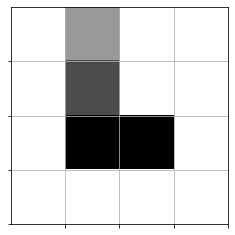

In [ ]:
qmaze = Qmaze(maze, rat_loc(maze))
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)
print(qmaze.visited)


{(0, 1), (1, 2), (1, 3), (0, 3), (1, 1)}
{(0, 1), (1, 2), (1, 3), (0, 2), (0, 3), (1, 1)}
not_over


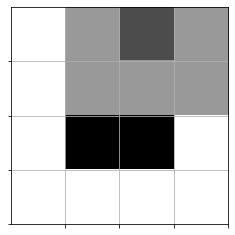

In [ ]:
qmaze.act(RIGHT)  # move right

print(qmaze.visited)
qmaze.act(UP)  # move up



print(qmaze.visited)
qmaze.act(LEFT)
qmaze.act(DOWN)
# qmaze.act(RIGHT)
# print(qmaze.visited)
print(qmaze.game_status())
show(qmaze)

In [ ]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [ ]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [ ]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [ ]:
def qtrain(model, maze ,loc ,   **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 50)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze,loc)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [ ]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

(4, 4)
not_over
win


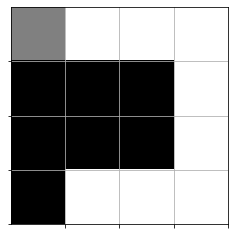

In [ ]:

maze =  np.array([
  [ 1.,  1.,  1.,  1.],
    [ 0.,  0.,  0.,  1.],
    [ 0.,  0.,  0.,  1.],
    [ 0.,  3.,  1.,  1.]
])
print(maze.shape)
start_loc = rat_loc(maze)
qmaze = Qmaze(maze, start_loc)

qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
print(qmaze.game_status())
qmaze.act(LEFT)
print(qmaze.game_status())
show(qmaze)


In [ ]:
model = build_model(maze)
qtrain(model, maze,start_loc ,  epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/49 | Loss: 831.8987 | Episodes: 3 | Win count: 1 | Win rate: 0.000 | time: 1.2 seconds
Epoch: 001/49 | Loss: 349.9643 | Episodes: 4 | Win count: 1 | Win rate: 0.000 | time: 3.0 seconds
Epoch: 002/49 | Loss: 304.2567 | Episodes: 1 | Win count: 1 | Win rate: 0.000 | time: 3.6 seconds
Epoch: 003/49 | Loss: 268.6237 | Episodes: 1 | Win count: 1 | Win rate: 0.000 | time: 4.4 seconds
Epoch: 004/49 | Loss: 43.1679 | Episodes: 65 | Win count: 1 | Win rate: 0.000 | time: 129.4 seconds
Epoch: 005/49 | Loss: 3.9268 | Episodes: 10 | Win count: 1 | Win rate: 0.000 | time: 151.2 seconds
Epoch: 006/49 | Loss: 0.5377 | Episodes: 16 | Win count: 1 | Win rate: 0.000 | time: 188.4 seconds
Epoch: 007/49 | Loss: 11.4822 | Episodes: 65 | Win count: 1 | Win rate: 0.000 | time: 333.4 seconds
Epoch: 008/49 | Loss: 13.3179 | Episodes: 1 | Win count: 1 | Win rate: 0.000 | time: 335.5 seconds
Epoch: 009/49 | Loss: 10.2689 | Episodes: 2 | Win count: 1 | Win rate: 0.000 | time: 339.9 seconds
Epoch: 010/4

2038.427225

(5, 5)
Epoch: 000/49 | Loss: 0.0447 | Episodes: 26 | Win count: 0 | Win rate: 0.000 | time: 28.1 seconds
Epoch: 001/49 | Loss: 0.0132 | Episodes: 101 | Win count: 0 | Win rate: 0.000 | time: 268.6 seconds


KeyboardInterrupt: ignored

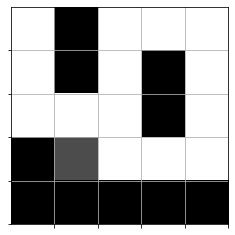

In [ ]:

test1 =  np.array([
  [ 1.,  0.,  1.,  1. , 1.],
    [ 1.,  0.,  1., 0.,  1.],
    [ 1.,  1., 1.,  0.,  1.],
    [ 0.,  3.,  1.,  1., 1.],
    [0., 0. , 0. ,0. , 0.]
])
print(test1.shape)
start_loc = rat_loc(test1)
qmaze = Qmaze(test1, start_loc)
show(qmaze)
model = build_model(test1)
qtrain(model, test1,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(5, 4)
Epoch: 000/49 | Loss: 0.0260 | Episodes: 24 | Win count: 0 | Win rate: 0.000 | time: 1.2 seconds
Epoch: 001/49 | Loss: 0.0238 | Episodes: 23 | Win count: 0 | Win rate: 0.000 | time: 2.4 seconds
Epoch: 002/49 | Loss: 0.5385 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 6.6 seconds
Epoch: 003/49 | Loss: 0.0113 | Episodes: 39 | Win count: 0 | Win rate: 0.000 | time: 8.8 seconds
Epoch: 004/49 | Loss: 0.0107 | Episodes: 11 | Win count: 0 | Win rate: 0.000 | time: 9.4 seconds
Epoch: 005/49 | Loss: 0.0313 | Episodes: 7 | Win count: 0 | Win rate: 0.000 | time: 9.7 seconds
Epoch: 006/49 | Loss: 0.0052 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 14.0 seconds
Epoch: 007/49 | Loss: 0.3781 | Episodes: 26 | Win count: 0 | Win rate: 0.000 | time: 15.4 seconds
Epoch: 008/49 | Loss: 0.0088 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 15.8 seconds
Epoch: 009/49 | Loss: 0.0170 | Episodes: 8 | Win count: 0 | Win rate: 0.000 | time: 16.3 seconds
Epoch: 010/49 | Loss: 

108.683385

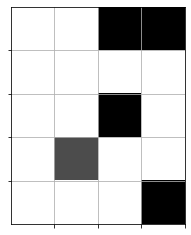

In [ ]:
test2 =  np.array([
  [ 1.,  1.,  0.,  0.],
    [ 1.,  1., 1.,  1.],
    [ 1.,  1., 0.,  1.],
    [ 1.,  3., 1., 1.],
    [1., 1. , 1., 0.]
])
print(test2.shape)
start_loc = rat_loc(test2)
qmaze = Qmaze(test2, start_loc)
show(qmaze)
model = build_model(test2)
qtrain(model, test2,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(5, 4)
Epoch: 000/49 | Loss: 0.0373 | Episodes: 14 | Win count: 0 | Win rate: 0.000 | time: 0.9 seconds
Epoch: 001/49 | Loss: 0.0389 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 1.1 seconds
Epoch: 002/49 | Loss: 0.0105 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 5.3 seconds
Epoch: 003/49 | Loss: 0.0128 | Episodes: 27 | Win count: 0 | Win rate: 0.000 | time: 6.8 seconds
Epoch: 004/49 | Loss: 0.0768 | Episodes: 13 | Win count: 0 | Win rate: 0.000 | time: 7.5 seconds
Epoch: 005/49 | Loss: 0.2974 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 11.8 seconds
Epoch: 006/49 | Loss: 0.3667 | Episodes: 32 | Win count: 0 | Win rate: 0.000 | time: 13.5 seconds
Epoch: 007/49 | Loss: 0.1950 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 17.8 seconds
Epoch: 008/49 | Loss: 0.0800 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 22.1 seconds
Epoch: 009/49 | Loss: 0.4857 | Episodes: 50 | Win count: 0 | Win rate: 0.000 | time: 24.7 seconds
Epoch: 010/49 | Los

112.679277

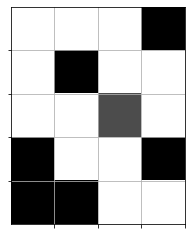

In [ ]:
test3 =  np.array([
  [ 1.,  1.,  1.,  0.],
    [ 1.,  0.,  1., 1.],
    [ 1.,  1., 3., 1.],
    [ 0., 1.,  1., 0.],
    [0., 0. , 1. , 1.]
])
print(test3.shape)
start_loc = rat_loc(test3)
qmaze = Qmaze(test3, start_loc)
show(qmaze)
model = build_model(test3)
qtrain(model, test3,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(4, 4)
Epoch: 000/49 | Loss: 0.0308 | Episodes: 65 | Win count: 0 | Win rate: 0.000 | time: 3.4 seconds
Epoch: 001/49 | Loss: 0.1318 | Episodes: 65 | Win count: 0 | Win rate: 0.000 | time: 6.9 seconds
Epoch: 002/49 | Loss: 0.3979 | Episodes: 65 | Win count: 0 | Win rate: 0.000 | time: 10.2 seconds
Epoch: 003/49 | Loss: 0.4421 | Episodes: 65 | Win count: 0 | Win rate: 0.000 | time: 13.7 seconds
Epoch: 004/49 | Loss: 0.0081 | Episodes: 65 | Win count: 0 | Win rate: 0.000 | time: 17.1 seconds
Epoch: 005/49 | Loss: 0.0109 | Episodes: 22 | Win count: 1 | Win rate: 0.000 | time: 18.3 seconds
Epoch: 006/49 | Loss: 0.5320 | Episodes: 35 | Win count: 2 | Win rate: 0.000 | time: 20.2 seconds
Epoch: 007/49 | Loss: 112.7016 | Episodes: 55 | Win count: 3 | Win rate: 0.000 | time: 23.9 seconds
Epoch: 008/49 | Loss: 4.0333 | Episodes: 34 | Win count: 3 | Win rate: 0.000 | time: 26.3 seconds
Epoch: 009/49 | Loss: 1.4400 | Episodes: 65 | Win count: 3 | Win rate: 0.375 | time: 30.7 seconds
Epoch: 010/49

132.042128

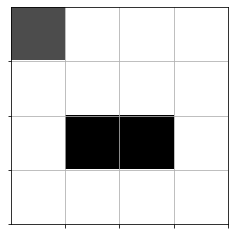

In [ ]:

test4 = np.array([
    [ 3.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  0.,  0.,  1.],
    [ 1.,  1.,  1.,  1.]
])
print(test4.shape)
start_loc = rat_loc(test4)
qmaze = Qmaze(test4, start_loc)
show(qmaze)
model = build_model(test4)
qtrain(model, test4,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(4, 5)
Epoch: 000/49 | Loss: 120.3579 | Episodes: 21 | Win count: 1 | Win rate: 0.000 | time: 1.1 seconds
Epoch: 001/49 | Loss: 15.3604 | Episodes: 81 | Win count: 1 | Win rate: 0.000 | time: 5.4 seconds
Epoch: 002/49 | Loss: 0.5233 | Episodes: 81 | Win count: 1 | Win rate: 0.000 | time: 9.7 seconds
Epoch: 003/49 | Loss: 1.7225 | Episodes: 27 | Win count: 1 | Win rate: 0.000 | time: 11.2 seconds
Epoch: 004/49 | Loss: 3.3920 | Episodes: 11 | Win count: 1 | Win rate: 0.000 | time: 11.8 seconds
Epoch: 005/49 | Loss: 3.2398 | Episodes: 13 | Win count: 2 | Win rate: 0.000 | time: 12.5 seconds
Epoch: 006/49 | Loss: 11.1532 | Episodes: 42 | Win count: 2 | Win rate: 0.000 | time: 14.8 seconds
Epoch: 007/49 | Loss: 7.2847 | Episodes: 24 | Win count: 3 | Win rate: 0.000 | time: 16.0 seconds
Epoch: 008/49 | Loss: 0.7914 | Episodes: 81 | Win count: 3 | Win rate: 0.000 | time: 20.4 seconds
Epoch: 009/49 | Loss: 1.3850 | Episodes: 45 | Win count: 3 | Win rate: 0.000 | time: 22.8 seconds
Epoch: 010/4

107.872266

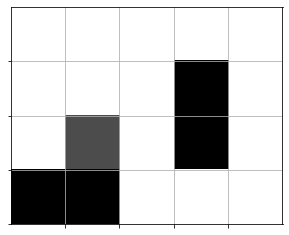

In [ ]:
test5 = np.array([
    [ 1.,  1.,  1., 1. , 1.],
    [ 1.,  1.,  1., 0. ,  1.],
    [ 1.,  3., 1. ,  0.,  1.],
    [ 0., 0. ,  1.,  1.,  1.]
])
print(test5.shape)
start_loc = rat_loc(test5)
qmaze = Qmaze(test5, start_loc)
show(qmaze)
model = build_model(test5)
qtrain(model, test5,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(5, 5)
Epoch: 000/49 | Loss: 132.8667 | Episodes: 19 | Win count: 1 | Win rate: 0.000 | time: 1.1 seconds
Epoch: 001/49 | Loss: 12.2027 | Episodes: 32 | Win count: 1 | Win rate: 0.000 | time: 2.7 seconds
Epoch: 002/49 | Loss: 8.4069 | Episodes: 21 | Win count: 2 | Win rate: 0.000 | time: 3.8 seconds
Epoch: 003/49 | Loss: 14.6740 | Episodes: 16 | Win count: 2 | Win rate: 0.000 | time: 4.7 seconds
Epoch: 004/49 | Loss: 17.0105 | Episodes: 38 | Win count: 3 | Win rate: 0.000 | time: 6.7 seconds
Epoch: 005/49 | Loss: 2.9797 | Episodes: 38 | Win count: 4 | Win rate: 0.000 | time: 8.8 seconds
Epoch: 006/49 | Loss: 2.8748 | Episodes: 28 | Win count: 4 | Win rate: 0.000 | time: 10.3 seconds
Epoch: 007/49 | Loss: 0.6197 | Episodes: 101 | Win count: 4 | Win rate: 0.000 | time: 15.7 seconds
Epoch: 008/49 | Loss: 5.6479 | Episodes: 25 | Win count: 5 | Win rate: 0.000 | time: 17.0 seconds
Epoch: 009/49 | Loss: 6.9374 | Episodes: 5 | Win count: 5 | Win rate: 0.000 | time: 17.3 seconds
Epoch: 010/49 

120.119495

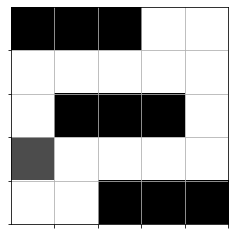

In [ ]:
test6 = np.array([
    [ 0., 0. ,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1. , 1.],
    [ 1.,  0.,  0., 0. , 1.],
    [ 3. , 1.,  1.,  1.,  1.],
    [1. , 1. , 0. , 0. , 0.]
])
print(test6.shape)
start_loc = rat_loc(test6)
qmaze = Qmaze(test6, start_loc)
show(qmaze)
model = build_model(test6)
qtrain(model, test6,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(5, 4)
Epoch: 000/49 | Loss: 0.0172 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 4.4 seconds
Epoch: 001/49 | Loss: 0.0179 | Episodes: 56 | Win count: 1 | Win rate: 0.000 | time: 7.4 seconds
Epoch: 002/49 | Loss: 0.8376 | Episodes: 81 | Win count: 1 | Win rate: 0.000 | time: 11.8 seconds
Epoch: 003/49 | Loss: 0.9794 | Episodes: 81 | Win count: 1 | Win rate: 0.000 | time: 16.3 seconds
Epoch: 004/49 | Loss: 1.5006 | Episodes: 46 | Win count: 2 | Win rate: 0.000 | time: 18.8 seconds
Epoch: 005/49 | Loss: 0.1051 | Episodes: 81 | Win count: 2 | Win rate: 0.000 | time: 23.2 seconds
Epoch: 006/49 | Loss: 0.7136 | Episodes: 19 | Win count: 2 | Win rate: 0.000 | time: 24.3 seconds
Epoch: 007/49 | Loss: 0.0350 | Episodes: 81 | Win count: 2 | Win rate: 0.000 | time: 28.7 seconds
Epoch: 008/49 | Loss: 0.0639 | Episodes: 5 | Win count: 2 | Win rate: 0.000 | time: 29.0 seconds
Epoch: 009/49 | Loss: 0.7214 | Episodes: 81 | Win count: 2 | Win rate: 0.000 | time: 33.4 seconds
Epoch: 010/49 | 

143.355654

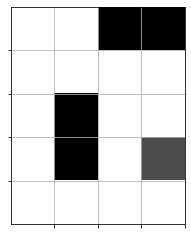

In [ ]:
test7 = np.array([
    [ 1.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.],
    [ 1.,  0.,  1.,  3.] ,
    [1. , 1. , 1. , 1.]
])
print(test7.shape)
start_loc = rat_loc(test7)
qmaze = Qmaze(test7, start_loc)
show(qmaze)
model = build_model(test7)
qtrain(model, test7,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(5, 5)
Epoch: 000/49 | Loss: 0.0098 | Episodes: 101 | Win count: 0 | Win rate: 0.000 | time: 5.4 seconds
Epoch: 001/49 | Loss: 0.5184 | Episodes: 36 | Win count: 0 | Win rate: 0.000 | time: 7.3 seconds
Epoch: 002/49 | Loss: 0.0124 | Episodes: 101 | Win count: 0 | Win rate: 0.000 | time: 12.8 seconds
Epoch: 003/49 | Loss: 0.0132 | Episodes: 101 | Win count: 0 | Win rate: 0.000 | time: 18.2 seconds
Epoch: 004/49 | Loss: 0.0391 | Episodes: 22 | Win count: 0 | Win rate: 0.000 | time: 19.4 seconds
Epoch: 005/49 | Loss: 0.0062 | Episodes: 101 | Win count: 0 | Win rate: 0.000 | time: 24.9 seconds
Epoch: 006/49 | Loss: 0.8607 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 25.2 seconds
Epoch: 007/49 | Loss: 0.6427 | Episodes: 31 | Win count: 0 | Win rate: 0.000 | time: 26.9 seconds
Epoch: 008/49 | Loss: 0.0099 | Episodes: 23 | Win count: 1 | Win rate: 0.000 | time: 28.2 seconds
Epoch: 009/49 | Loss: 0.1534 | Episodes: 13 | Win count: 1 | Win rate: 0.000 | time: 28.9 seconds
Epoch: 010/4

111.804546

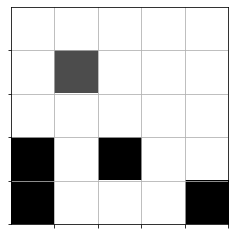

In [ ]:
test8 = np.array([
    [ 1., 1. ,  1.,  1.,  1.],
    [ 1.,  3. , 1.,  1.,  1.],
    [ 1.,  1.,  1., 1. ,  1.],
    [ 0.,  1.,  0.,  1. , 1.],
    [0. , 1. , 1. , 1. , 0.]
])
print(test8.shape)
start_loc = rat_loc(test8)
qmaze = Qmaze(test8, start_loc)
show(qmaze)
model = build_model(test8)
qtrain(model, test8,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(5, 6)
Epoch: 000/49 | Loss: 0.0330 | Episodes: 23 | Win count: 0 | Win rate: 0.000 | time: 1.4 seconds
Epoch: 001/49 | Loss: 0.0259 | Episodes: 25 | Win count: 0 | Win rate: 0.000 | time: 2.7 seconds
Epoch: 002/49 | Loss: 0.0147 | Episodes: 15 | Win count: 0 | Win rate: 0.000 | time: 3.5 seconds
Epoch: 003/49 | Loss: 0.0131 | Episodes: 121 | Win count: 0 | Win rate: 0.000 | time: 9.9 seconds
Epoch: 004/49 | Loss: 0.0082 | Episodes: 27 | Win count: 0 | Win rate: 0.000 | time: 11.4 seconds
Epoch: 005/49 | Loss: 0.0158 | Episodes: 121 | Win count: 0 | Win rate: 0.000 | time: 17.9 seconds
Epoch: 006/49 | Loss: 0.0058 | Episodes: 22 | Win count: 0 | Win rate: 0.000 | time: 19.0 seconds
Epoch: 007/49 | Loss: 0.0434 | Episodes: 32 | Win count: 1 | Win rate: 0.000 | time: 20.7 seconds
Epoch: 008/49 | Loss: 2.0038 | Episodes: 28 | Win count: 1 | Win rate: 0.000 | time: 22.2 seconds
Epoch: 009/49 | Loss: 4.0313 | Episodes: 21 | Win count: 2 | Win rate: 0.000 | time: 23.3 seconds
Epoch: 010/49 |

128.419019

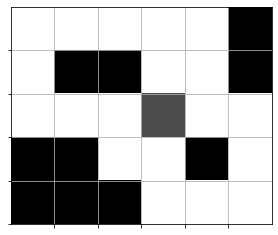

In [ ]:
test9 = np.array([
    [ 1., 1.,  1.,  1.,  1. , 0.],
    [ 1.,  0., 0.,  1.,  1. , 0.],
    [ 1.,  1.,  1., 3. , 1. ,  1.],
    [ 0. , 0. , 1.,  1.,  0.,  1.],
    [0. ,0. , 0. , 1. , 1. , 1.]
])
print(test9.shape)
start_loc = rat_loc(test9)
qmaze = Qmaze(test9, start_loc)
show(qmaze)
model = build_model(test9)
qtrain(model, test9,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(5, 5)
Epoch: 000/49 | Loss: 0.0315 | Episodes: 14 | Win count: 0 | Win rate: 0.000 | time: 0.9 seconds
Epoch: 001/49 | Loss: 79.1068 | Episodes: 29 | Win count: 1 | Win rate: 0.000 | time: 2.3 seconds
Epoch: 002/49 | Loss: 9.4921 | Episodes: 35 | Win count: 2 | Win rate: 0.000 | time: 4.2 seconds
Epoch: 003/49 | Loss: 0.9315 | Episodes: 101 | Win count: 2 | Win rate: 0.000 | time: 9.7 seconds
Epoch: 004/49 | Loss: 2.5789 | Episodes: 26 | Win count: 2 | Win rate: 0.000 | time: 11.1 seconds
Epoch: 005/49 | Loss: 18.3017 | Episodes: 42 | Win count: 3 | Win rate: 0.000 | time: 13.4 seconds
Epoch: 006/49 | Loss: 1.6199 | Episodes: 101 | Win count: 3 | Win rate: 0.000 | time: 18.9 seconds
Epoch: 007/49 | Loss: 0.6038 | Episodes: 23 | Win count: 3 | Win rate: 0.000 | time: 20.1 seconds
Epoch: 008/49 | Loss: 1.5783 | Episodes: 36 | Win count: 4 | Win rate: 0.000 | time: 22.1 seconds
Epoch: 009/49 | Loss: 52.5937 | Episodes: 37 | Win count: 5 | Win rate: 0.000 | time: 24.2 seconds
Epoch: 010/4

117.690402

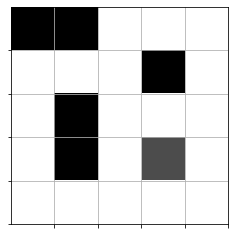

In [ ]:
test10 = np.array([
    [ 0., 0.,  1.,  1.,  1. ],
    [ 1.,  1., 1.,  0.,  1.],
    [ 1.,  0.,  1., 1. ,  1.],
    [ 1. , 0. , 1.,  3., 1.],
    [1. ,1., 1. , 1. , 1.]
])
print(test10.shape)
start_loc = rat_loc(test10)
qmaze = Qmaze(test10, start_loc)
show(qmaze)
model = build_model(test10)
qtrain(model, test10,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 0.0031 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 7.9 seconds
Epoch: 001/49 | Loss: 0.0187 | Episodes: 31 | Win count: 0 | Win rate: 0.000 | time: 9.5 seconds
Epoch: 002/49 | Loss: 0.6000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 17.4 seconds
Epoch: 003/49 | Loss: 0.0092 | Episodes: 42 | Win count: 0 | Win rate: 0.000 | time: 19.7 seconds
Epoch: 004/49 | Loss: 0.0097 | Episodes: 20 | Win count: 0 | Win rate: 0.000 | time: 20.8 seconds
Epoch: 005/49 | Loss: 0.0227 | Episodes: 19 | Win count: 0 | Win rate: 0.000 | time: 21.9 seconds
Epoch: 006/49 | Loss: 0.1443 | Episodes: 33 | Win count: 1 | Win rate: 0.000 | time: 23.7 seconds
Epoch: 007/49 | Loss: 6.6901 | Episodes: 8 | Win count: 1 | Win rate: 0.000 | time: 24.1 seconds
Epoch: 008/49 | Loss: 3.9485 | Episodes: 24 | Win count: 1 | Win rate: 0.000 | time: 25.4 seconds
Epoch: 009/49 | Loss: 6.7268 | Episodes: 12 | Win count: 1 | Win rate: 0.000 | time: 26.1 seconds
Epoch: 010/49 

182.708981

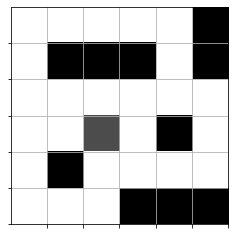

In [ ]:
test6_1 = np.array([
    [ 1.,  1.,  1., 1. , 1. , 0.],
    [ 1.,  0.,  0., 0. ,  1. , 0.],
    [ 1.,  1., 1. ,  1.,  1. , 1.],
    [ 1., 1. ,  3.,  1., 0.,   1.] , 
    [1. ,0. , 1. , 1. , 1. ,1.] , 
    [1. , 1. ,1. ,0. ,0., 0. ]
])

print(test6_1.shape)
start_loc = rat_loc(test6_1)
qmaze = Qmaze(test6_1, start_loc)
show(qmaze)
model = build_model(test6_1)
qtrain(model, test6_1,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 0.0261 | Episodes: 28 | Win count: 0 | Win rate: 0.000 | time: 1.5 seconds
Epoch: 001/49 | Loss: 0.0178 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 1.9 seconds
Epoch: 002/49 | Loss: 0.0089 | Episodes: 10 | Win count: 0 | Win rate: 0.000 | time: 2.4 seconds
Epoch: 003/49 | Loss: 0.0110 | Episodes: 24 | Win count: 0 | Win rate: 0.000 | time: 3.8 seconds
Epoch: 004/49 | Loss: 0.0053 | Episodes: 19 | Win count: 0 | Win rate: 0.000 | time: 4.8 seconds
Epoch: 005/49 | Loss: 0.0138 | Episodes: 25 | Win count: 0 | Win rate: 0.000 | time: 6.2 seconds
Epoch: 006/49 | Loss: 0.0122 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 6.8 seconds
Epoch: 007/49 | Loss: 0.0095 | Episodes: 8 | Win count: 0 | Win rate: 0.000 | time: 7.2 seconds
Epoch: 008/49 | Loss: 0.0148 | Episodes: 14 | Win count: 0 | Win rate: 0.000 | time: 8.0 seconds
Epoch: 009/49 | Loss: 0.0133 | Episodes: 17 | Win count: 0 | Win rate: 0.000 | time: 9.0 seconds
Epoch: 010/49 | Loss: 0.05

82.31282

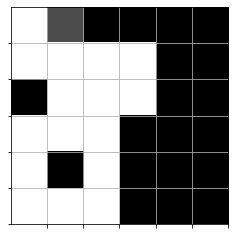

In [ ]:
test6_2 = np.array([
    [ 1.,  3.,  0., 0. , 0. , 0.],
    [ 1.,  1.,  1., 1. ,  0. , 0.],
    [ 0.,  1., 1. ,  1.,  0. , 0.],
    [ 1., 1. ,  1.,  0., 0.,   0.] , 
    [1. ,0. , 1. , 0. , 0. ,0.] , 
    [1. , 1. ,1. ,0. ,0., 0. ]
])

print(test6_2.shape)
start_loc = rat_loc(test6_2)
qmaze = Qmaze(test6_2, start_loc)
show(qmaze)
model = build_model(test6_2)
qtrain(model, test6_2,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 1.0662 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 8.2 seconds
Epoch: 001/49 | Loss: 0.7909 | Episodes: 18 | Win count: 0 | Win rate: 0.000 | time: 9.2 seconds
Epoch: 002/49 | Loss: 0.9730 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 17.4 seconds
Epoch: 003/49 | Loss: 0.9203 | Episodes: 7 | Win count: 0 | Win rate: 0.000 | time: 17.8 seconds
Epoch: 004/49 | Loss: 0.8832 | Episodes: 5 | Win count: 0 | Win rate: 0.000 | time: 18.0 seconds
Epoch: 005/49 | Loss: 0.0044 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 26.2 seconds
Epoch: 006/49 | Loss: 0.8756 | Episodes: 11 | Win count: 0 | Win rate: 0.000 | time: 26.8 seconds
Epoch: 007/49 | Loss: 0.0010 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 34.9 seconds
Epoch: 008/49 | Loss: 0.0037 | Episodes: 13 | Win count: 0 | Win rate: 0.000 | time: 35.6 seconds
Epoch: 009/49 | Loss: 0.0068 | Episodes: 19 | Win count: 0 | Win rate: 0.000 | time: 36.7 seconds
Epoch: 010/49

119.399485

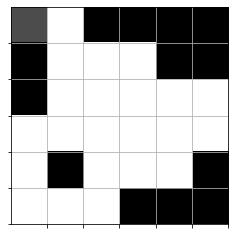

In [ ]:
test6_3 = np.array([
    [ 3.,  1.,  0., 0. , 0. , 0.],
    [ 0.,  1.,  1., 1. ,  0. , 0.],
    [ 0.,  1., 1. , 1.,  1. , 1.],
    [ 1.,  1. ,1.,  1., 1.,  1.] , 
    [1.,   0. , 1. , 1. , 1. ,0.] , 
    [1. , 1. ,1. ,0. ,0., 0. ]
])

print(test6_3.shape)
start_loc = rat_loc(test6_3)
qmaze = Qmaze(test6_3, start_loc)
show(qmaze)
model = build_model(test6_3)
qtrain(model, test6_3,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 0.0270 | Episodes: 18 | Win count: 0 | Win rate: 0.000 | time: 1.0 seconds
Epoch: 001/49 | Loss: 0.0208 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 1.5 seconds
Epoch: 002/49 | Loss: 0.0165 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 1.5 seconds
Epoch: 003/49 | Loss: 0.0102 | Episodes: 35 | Win count: 0 | Win rate: 0.000 | time: 3.4 seconds
Epoch: 004/49 | Loss: 0.0894 | Episodes: 30 | Win count: 0 | Win rate: 0.000 | time: 5.1 seconds
Epoch: 005/49 | Loss: 0.0368 | Episodes: 5 | Win count: 0 | Win rate: 0.000 | time: 5.4 seconds
Epoch: 006/49 | Loss: 0.0616 | Episodes: 41 | Win count: 0 | Win rate: 0.000 | time: 7.7 seconds
Epoch: 007/49 | Loss: 0.0440 | Episodes: 2 | Win count: 0 | Win rate: 0.000 | time: 7.8 seconds
Epoch: 008/49 | Loss: 0.0367 | Episodes: 18 | Win count: 0 | Win rate: 0.000 | time: 8.8 seconds
Epoch: 009/49 | Loss: 0.0520 | Episodes: 23 | Win count: 0 | Win rate: 0.000 | time: 10.1 seconds
Epoch: 010/49 | Loss: 0.09

104.282689

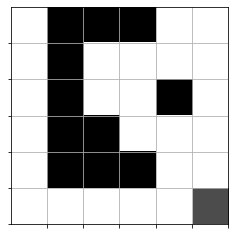

In [ ]:
test6_4 = np.array([
    [ 1.,  0.,  0., 0. , 1. , 1.],
    [ 1.,  0.,  1., 1. ,  1. , 1.],
    [ 1.,  0., 1. ,  1.,  0. , 1.],
    [ 1., 0. ,  0.,  1., 1.,   1.] , 
    [1. ,0. , 0. , 0. , 1. ,1.] , 
    [1. , 1. ,1. ,1. ,1., 3. ]
])

print(test6_4.shape)
start_loc = rat_loc(test6_4)
qmaze = Qmaze(test6_4, start_loc)
show(qmaze)
model = build_model(test6_4)
qtrain(model, test6_4,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 0.0343 | Episodes: 31 | Win count: 0 | Win rate: 0.000 | time: 1.7 seconds
Epoch: 001/49 | Loss: 0.0264 | Episodes: 11 | Win count: 0 | Win rate: 0.000 | time: 2.3 seconds
Epoch: 002/49 | Loss: 0.0080 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 10.4 seconds
Epoch: 003/49 | Loss: 1.1306 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 18.5 seconds
Epoch: 004/49 | Loss: 0.0123 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 26.6 seconds
Epoch: 005/49 | Loss: 0.0041 | Episodes: 17 | Win count: 0 | Win rate: 0.000 | time: 27.6 seconds
Epoch: 006/49 | Loss: 0.8701 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 27.6 seconds
Epoch: 007/49 | Loss: 0.0002 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 35.7 seconds
Epoch: 008/49 | Loss: 0.0047 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 43.8 seconds
Epoch: 009/49 | Loss: 0.7500 | Episodes: 29 | Win count: 0 | Win rate: 0.000 | time: 45.4 seconds
Epoch: 010/

231.141655

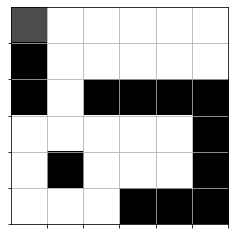

In [ ]:
test6_5 = np.array([
    [ 3.,  1.,  1., 1. , 1. , 1.],
    [ 0.,  1.,  1., 1. ,  1. , 1.],
    [ 0.,  1., 0.,0.,  0. , 0.],
    [ 1., 1., 1., 1., 1., 0.] , 
    [1. ,0. , 1. , 1. , 1. ,0.] , 
    [1. , 1. ,1. ,0. ,0., 0. ]
])

print(test6_5.shape)
start_loc = rat_loc(test6_5)
qmaze = Qmaze(test6_5, start_loc)
show(qmaze)
model = build_model(test6_5)
qtrain(model, test6_5,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 0.0325 | Episodes: 3 | Win count: 0 | Win rate: 0.000 | time: 0.7 seconds
Epoch: 001/49 | Loss: 0.0366 | Episodes: 7 | Win count: 0 | Win rate: 0.000 | time: 0.8 seconds
Epoch: 002/49 | Loss: 0.0283 | Episodes: 18 | Win count: 0 | Win rate: 0.000 | time: 1.5 seconds
Epoch: 003/49 | Loss: 0.0266 | Episodes: 13 | Win count: 0 | Win rate: 0.000 | time: 2.2 seconds
Epoch: 004/49 | Loss: 0.0189 | Episodes: 13 | Win count: 0 | Win rate: 0.000 | time: 3.0 seconds
Epoch: 005/49 | Loss: 0.0026 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 10.9 seconds
Epoch: 006/49 | Loss: 0.0056 | Episodes: 5 | Win count: 0 | Win rate: 0.000 | time: 11.2 seconds
Epoch: 007/49 | Loss: 0.0035 | Episodes: 27 | Win count: 0 | Win rate: 0.000 | time: 12.6 seconds
Epoch: 008/49 | Loss: 0.0330 | Episodes: 55 | Win count: 0 | Win rate: 0.000 | time: 15.6 seconds
Epoch: 009/49 | Loss: 0.1082 | Episodes: 36 | Win count: 0 | Win rate: 0.000 | time: 17.6 seconds
Epoch: 010/49 | Loss

73.121783

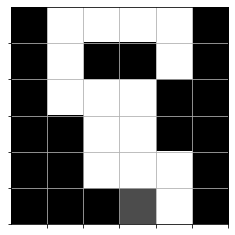

In [ ]:
#wrong
test6_6 = np.array([
    [ 0.,  1.,  1., 1. , 1. , 0.],
    [ 0.,  1.,  0., 0. ,  1. , 0.],
    [ 0.,  1., 1. ,  1.,  0. , 0.],
    [ 0., 0. ,  1.,  1., 0.,   0.] , 
    [0. ,0. , 1. , 1. , 1. ,0.] , 
    [0. , 0. ,0. ,3. ,1., 0. ]
])
print(test6_6.shape)
start_loc = rat_loc(test6_6)
qmaze = Qmaze(test6_6, start_loc)
show(qmaze)
model = build_model(test6_6)
qtrain(model, test6_6,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 0.0411 | Episodes: 3 | Win count: 0 | Win rate: 0.000 | time: 1.0 seconds
Epoch: 001/49 | Loss: 0.0330 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 1.6 seconds
Epoch: 002/49 | Loss: 0.0308 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 1.6 seconds
Epoch: 003/49 | Loss: 0.0270 | Episodes: 16 | Win count: 0 | Win rate: 0.000 | time: 2.5 seconds
Epoch: 004/49 | Loss: 0.0138 | Episodes: 26 | Win count: 0 | Win rate: 0.000 | time: 4.4 seconds
Epoch: 005/49 | Loss: 0.0151 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 4.4 seconds
Epoch: 006/49 | Loss: 0.0220 | Episodes: 28 | Win count: 0 | Win rate: 0.000 | time: 6.0 seconds
Epoch: 007/49 | Loss: 0.0185 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 6.5 seconds
Epoch: 008/49 | Loss: 0.0259 | Episodes: 25 | Win count: 1 | Win rate: 0.000 | time: 7.9 seconds
Epoch: 009/49 | Loss: 0.2865 | Episodes: 14 | Win count: 1 | Win rate: 0.000 | time: 8.7 seconds
Epoch: 010/49 | Loss: 1.8222

88.00124

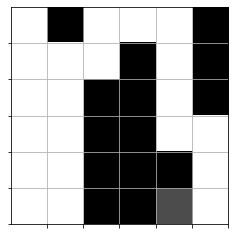

In [ ]:
test6_7 = np.array([
    [ 1.,  0.,  1., 1. , 1. , 0.],
    [ 1.,  1.,  1., 0. ,  1. , 0.],
    [ 1.,  1., 0. ,  0.,  1. , 0.],
    [ 1., 1. ,  0.,  0., 1.,   1.] , 
    [1. ,1. , 0. , 0. , 0. ,1.] , 
    [1. , 1. ,0. ,0. ,3., 1. ]
])
print(test6_7.shape)
start_loc = rat_loc(test6_7)
qmaze = Qmaze(test6_7, start_loc)
show(qmaze)
model = build_model(test6_7)
qtrain(model, test6_7,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)

(6, 6)
Epoch: 000/49 | Loss: 0.9456 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 8.1 seconds
Epoch: 001/49 | Loss: 0.6046 | Episodes: 25 | Win count: 0 | Win rate: 0.000 | time: 9.4 seconds
Epoch: 002/49 | Loss: 0.0122 | Episodes: 13 | Win count: 0 | Win rate: 0.000 | time: 10.2 seconds
Epoch: 003/49 | Loss: 0.3869 | Episodes: 7 | Win count: 0 | Win rate: 0.000 | time: 10.6 seconds
Epoch: 004/49 | Loss: 0.3286 | Episodes: 24 | Win count: 0 | Win rate: 0.000 | time: 11.9 seconds
Epoch: 005/49 | Loss: 0.0091 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 12.2 seconds
Epoch: 006/49 | Loss: 0.0134 | Episodes: 14 | Win count: 0 | Win rate: 0.000 | time: 13.0 seconds
Epoch: 007/49 | Loss: 0.0214 | Episodes: 33 | Win count: 0 | Win rate: 0.000 | time: 14.8 seconds
Epoch: 008/49 | Loss: 0.0251 | Episodes: 31 | Win count: 0 | Win rate: 0.000 | time: 16.5 seconds
Epoch: 009/49 | Loss: 0.0263 | Episodes: 16 | Win count: 0 | Win rate: 0.000 | time: 17.4 seconds
Epoch: 010/49 | 

75.211118

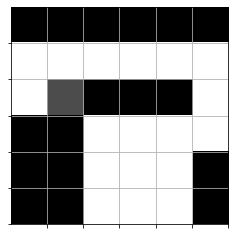

In [ ]:
test6_8 = np.array([
    [ 0.,  0.,  0., 0. , 0. , 0.],
    [ 1.,  1.,  1., 1. ,  1. , 1.],
    [ 1.,  3., 0. ,  0.,  0. , 1.],
    [ 0., 0. ,  1.,  1., 1.,   1.] , 
    [0. ,0. , 1. , 1. , 1. ,0.] , 
    [0. , 0. ,1. ,1. ,1., 0. ]
])
print(test6_8.shape)
start_loc = rat_loc(test6_8)
qmaze = Qmaze(test6_8, start_loc)
show(qmaze)
model = build_model(test6_8)
qtrain(model, test6_8,start_loc, epochs=1000, max_memory=8*maze.size, data_size=32)